In [1]:
import os
import copy

import numpy as np
import torch
import torch.nn as nn
import math

from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from unet import UNet
from dice_loss import dice_coeff
####################################################
# for data splitting
####################################################
import pandas as pd
####################################################
# for data preparation
####################################################
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score
####################################################
# for plotting
####################################################
import matplotlib.pyplot as plt
from IPython.display import clear_output
############################
# Helper func
############################
from helper import * 
###################################
TRAIN_RATIO = 0.8
RS = 30448
N_CHANNELS, N_CLASSES = 1, 1 
bilinear = True
BATCH_SIZE, EPOCHS = 4, 500
IMAGE_SIZE = (600, 600)
CROP_SIZE = (600, 600)



In [2]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
CLIENTS = ['miccai', 'bns']
CLIENTS_2 = [cl + '_2' for cl in CLIENTS]
###################################################################
TOTAL_CLIENTS = len(CLIENTS)

DIR_DATA = 'data/imagesTrAug/'
DIR_GT = 'data/labelsTrBW/'

skin_dataset = dict()
skin_dataset['miccai'] = ['miccai_{:03d}'.format(i) for i in range(201, 227)]
skin_dataset['bns'] = ['bns_{:03d}'.format(i) for i in range(181, 204)]

split_dataset = dict()
STATIC_WEIGHT = [0,0]
order = 0

for client in skin_dataset:
    tmp = skin_dataset[client]
    x_ = [os.path.join(DIR_DATA, f + '.png') for f in tmp]
    y_ = [os.path.join(DIR_GT, f + '.png') for f in tmp]
    
    x_train, x_test, y_train, y_test = train_test_split(
        x_, y_, test_size=1 - TRAIN_RATIO, random_state=RS)

    split_dataset[client + '_train'] = Cancer(x_train, y_train, train=True, \
                                              IMAGE_SIZE=IMAGE_SIZE \
                                              , CROP_SIZE=CROP_SIZE)
    STATIC_WEIGHT[order] = len(x_train)
    order += 1

    split_dataset[client + '_test'] = Cancer(x_test, y_test, train=False, \
                                             IMAGE_SIZE=IMAGE_SIZE \
                                             , CROP_SIZE=CROP_SIZE)
    print(client)


# Aggiungi le immagini rimanenti di Miccai al set di addestramento di Miccai
miccai_remaining = ['miccai_{:03d}'.format(i) for i in range(1, 201)]  # Immagini non ancora aggiunte
miccai_train = split_dataset['miccai_train'].data  # Percorsi delle immagini già nel set di addestramento di Miccai
miccai_remaining = [os.path.join(DIR_DATA, f + '.png') for f in miccai_remaining if f not in miccai_train]
split_dataset['miccai_train'].data.extend(miccai_remaining)

# Aggiungi le immagini rimanenti di Bns al set di addestramento di Bns
bns_remaining = ['bns_{:03d}'.format(i) for i in range(1, 181)]  # Immagini non ancora aggiunte
bns_train = split_dataset['bns_train'].data  # Percorsi delle immagini già nel set di addestramento di Bns
bns_remaining = [os.path.join(DIR_DATA, f + '.png') for f in bns_remaining if f not in bns_train]
split_dataset['bns_train'].data.extend(bns_remaining)


miccai
bns


In [4]:
STATIC_WEIGHT = [item / sum(STATIC_WEIGHT) for item in STATIC_WEIGHT]
print(STATIC_WEIGHT)
WEIGHTS = STATIC_WEIGHT
WEIGHTS_DATA = copy.deepcopy(WEIGHTS)

[0.5263157894736842, 0.47368421052631576]


In [5]:
device = torch.device('cuda:0')
LR, WD, TH = 1e-3, 1e-4, 0.9
best_avg_acc, best_epoch = 0.0, 0

In [6]:
training_clients, testing_clients = dict(), dict()
training_clients_pl = dict()

acc_train, acc_test, loss_train, loss_test = dict(), dict(), \
                                            dict(), dict()
    
nets, optimizers = dict(), dict()

nets['global'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)

nets['global_2'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)

for client in CLIENTS:
    print(client)
    training_clients[client] = DataLoader(split_dataset[client+'_train'], batch_size=4,\
                 shuffle=True, num_workers=8)
    training_clients_pl[client] = DataLoader(split_dataset[client+'_train'], batch_size=1, \
                shuffle=True, num_workers=8)
    ###################################################################################
    testing_clients[client] = DataLoader(split_dataset[client+'_test'], batch_size=1,\
                         shuffle=False, num_workers=1)
    
    acc_train[client], acc_test[client] = [], []
    loss_train[client], loss_test[client] = [], []
        
    nets[client] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)
    nets[client+'_2'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)
    optimizers[client]= optim.Adam(nets[client].parameters(), \
                                   lr=LR,weight_decay=WD)
    optimizers[client+'_2']= optim.Adam(nets[client+'_2'].parameters(), \
                                   lr=LR,weight_decay=WD)

miccai
bns


In [7]:
# CLIENTS_SUPERVISION = ['unlabeled', 'unlabeled', 'labeled', 'unlabeled'] # [U,U,L,U]
CLIENTS_SUPERVISION = ['labeled','labeled'] # [B, B, L, B]

In [20]:
LAMBDA_ = 10
BETA_ = 3
TH = 0.7

# FedMix

0.22041263276090226 0.22192438133060932
[0.5067004507350572, 0.49329954926494285]


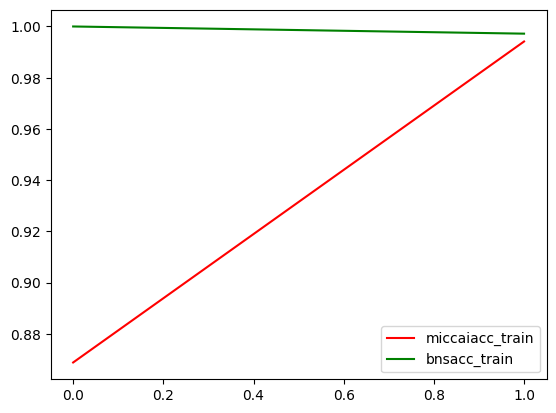

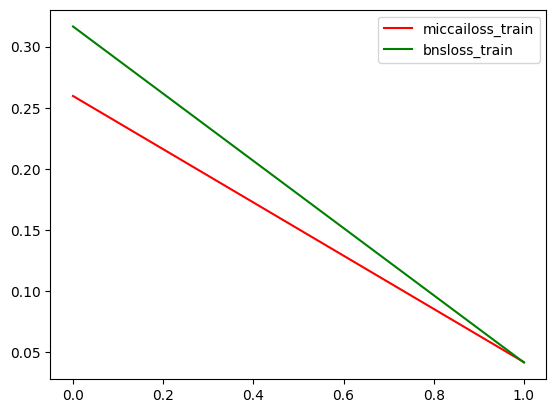

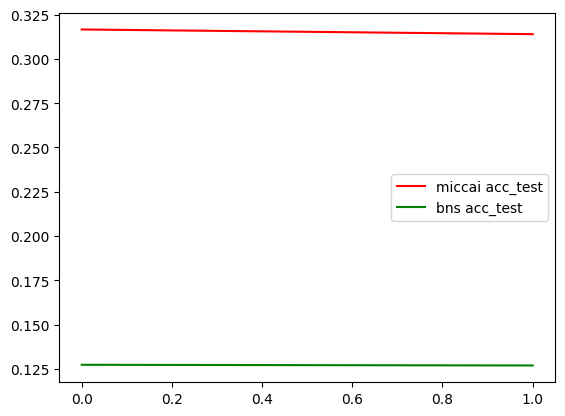

KeyboardInterrupt: 

In [21]:
best_avg_acc, best_epoch_avg = 0,0
index = []

for client in CLIENTS:
    acc_train[client], acc_test[client] = [], []
    loss_train[client], loss_test[client] = [], []

WEIGHTS = [0.0, 0.0]
DATA_NUM = [0,0]
score = [0,0]
count=0

for epoch in range(EPOCHS):        
    index.append(epoch)
    DATA_NUM = [0,0]
    #################### copy fed model ###################
    copy_fed(CLIENTS, nets, fed_name='global')
    copy_fed(CLIENTS_2, nets, fed_name='global_2')
    
    ######################################################
    # generate and refine pseudo labels ##################
    ######################################################
    for order, client in enumerate(CLIENTS):
        bbox, image = False, False
        if CLIENTS_SUPERVISION[order] == 'labeled':
            count=0
        elif CLIENTS_SUPERVISION[order] == 'bbox':
            bbox = True
        elif CLIENTS_SUPERVISION[order] == 'image':
            image= True
        ##################################################
        # save pl ########################################
        ##################################################
        im_store, pl1_store, pl2_store = [], [], []
        
        tmp_ = select_pl_singleclass(nets['global'], nets['global_2'], device,\
                      training_clients_pl[client], im_store, pl1_store, \
                      pl2_store, TH=TH, bbox=bbox, image=image)
        
        if len(im_store) >= 1:
            tmp_dataset = cancer_v2(im_store, pl1_store, pl2_store)
            training_clients[client] = DataLoader(tmp_dataset, batch_size=4,\
                             shuffle=True, num_workers=8)

        DATA_NUM[order] = tmp_
    #######################################################
    #### Conduct training #################################
    #######################################################
    for order, (client, supervision_t) in enumerate(zip(CLIENTS, CLIENTS_SUPERVISION)):
        if supervision_t == 'labeled':
            # train network 1 #
            train_model(training_clients[client], nets[client], optimizers[client], device, \
                       acc=acc_train[client], loss=loss_train[client], \
                        supervision_type=supervision_t)
            
            # train network 2 # 
            train_model(training_clients[client], nets[client+'_2'], optimizers[client+'_2'], device, \
                       acc=None, loss=None, \
                        supervision_type=supervision_t)
            
        else: # train using pseudo label # 
            # train network 1 #
            train_model(training_clients[client], nets[client], optimizers[client], device, \
                       acc=acc_train[client], loss=loss_train[client], \
                        supervision_type=supervision_t, FedMix_network=1)
            
            # train network 2 # 
            train_model(training_clients[client], nets[client+'_2'], optimizers[client+'_2'], device, \
                       acc=None, loss=None, \
                        supervision_type=supervision_t, FedMix_network=2)
        
        
        # save loss for future reweighting # 
        score[order] = loss_train[client][-1] ** BETA_
    ###################################
    ####### dynamic weighting #########
    ###################################
    denominator = sum(score)
    score = [s/denominator for s in score]
    
    denominator = sum(DATA_NUM)
    WEIGHTS_CL = [s/denominator for s in DATA_NUM]
    for order, _ in enumerate(WEIGHTS):
        WEIGHTS[order] = WEIGHTS_CL[order] + LAMBDA_ * score[order]
        
    ### normalize #####################
    denominator = sum(WEIGHTS)
    WEIGHTS = [w/denominator for w in WEIGHTS]

    ###################################
    ####### aggregation ###############
    ###################################
    aggr_fed(CLIENTS, WEIGHTS, nets, fed_name='global')
    aggr_fed(CLIENTS_2, WEIGHTS, nets, fed_name='global_2')
    
    
    avg_acc = 0.0
    for client in CLIENTS:
        test(epoch, testing_clients[client], nets['global'], device, acc_test[client],\
             loss_test[client])
        avg_acc += acc_test[client][-1]
        
    avg_acc = avg_acc / TOTAL_CLIENTS
    ############################################################
    ########################################################
    if avg_acc > best_avg_acc:
        best_avg_acc = avg_acc
        best_epoch = epoch
        # Salvataggio del modello per Miccai e Bns
        torch.save(nets['miccai'].state_dict(), 'best_model_miccai.pt')
        torch.save(nets['bns'].state_dict(), 'best_model_bns.pt')
        torch.save(nets['global'].state_dict(), 'best_fed_model.pt')
    ################################
    # plot #########################
    ################################
    clear_output(wait=True)
    print(avg_acc, best_avg_acc)
    print(WEIGHTS)
    plot_graphs(0, CLIENTS, index, acc_train, 'acc_train')
    plot_graphs(1, CLIENTS, index, loss_train, 'loss_train')
    plot_graphs(2, CLIENTS, index, acc_test, ' acc_test')

print(best_avg_acc, best_epoch)
for client in CLIENTS:
    print(client)
    tmp = best_epoch
    best_epoch = best_epoch 
    print("shared epoch specific")
    print(acc_test[client][best_epoch])
    print("max client-specific")
    print(np.max(acc_test[client]))
    best_epoch = tmp